# Best Neighborhood for Dining

## Introduction

### Metric
Our determination of the best neighborhood is based on the metric of the best neighborhood for dining. This is done by analzying the quality of the restauraunts in the neighborhood, based on average ratings, and the likelyhood that patrons will die at a restauraunt, based on health violations and nearby fire and police incidents (excluding traffic citations).

Datasets:
- Pittsburgh Restauraunt Data
- Fire Incidents
- Police Incidents
- Health Violations

## Restauraunt Data Generation
The restauraunt data set was gathered using the Places API of the Google Maps Platform. To find restauraunts and cafes in the Pittsburgh, points spread at a regular interval within Pittsburgh were sampled using the Place Search feature, which returns a list of relevant listings in a specified radius of the point. To get the points, we needed to represent the area contained within Pittsburgh. This was the source image that was used.

![Pittsburgh Neighborhoods](Pittsburgh_Pennsylvania_neighborhoods.svg)

The SVG file was edited to be a black and white map, with black pixels representating areas inside Pittsburgh.

![Pittsburgh Boundary Map](pittsburgh.png)

Points were generated on a grid, spaced 1 km apart. These were then checked to see if they were within Pittsburgh.

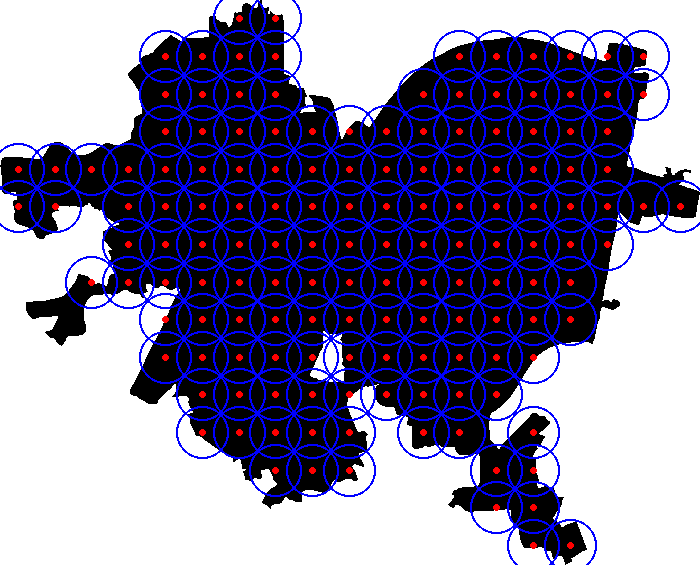

In [2]:
import math
from PIL import Image, ImageDraw

# CONFIG - Search parameters
SPACING = 1

# Geographical information
SOUTH_LIMIT = 40.361370
WEST_LIMIT = -80.095286
NORTH_LIMIT = 40.500925
EAST_LIMIT = -79.865750
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Import map
map = Image.open("datasets/business_list/assets/pittsburgh.png")
map.load()
drawer = ImageDraw.Draw(map)

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

RADIUS_PIXELS = math.ceil(RADIUS * map.width / WEST_EAST_DIST_KM)

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            drawer.ellipse((pixel_x - 3, pixel_y - 3, pixel_x + 3, pixel_y + 3), fill="red")
            drawer.ellipse((pixel_x - RADIUS_PIXELS, pixel_y - RADIUS_PIXELS, pixel_x + RADIUS_PIXELS, pixel_y + RADIUS_PIXELS), outline="blue", width=2)

map

If the point was within the boundary (it fell on a black pixel), then it was converted to its corresponding geographical coordinates and used to query the API. The search radius is set to 1.414 km, or sqrt(2) times the spacing to ensure the search covers the entire area. Then, each location returned is queried using Place Details to get more information about each establishment.

In [ ]:
import math, json, time
import googlemaps
from PIL import Image

class API_Session:
    def __init__(self, api_key):
        self.client = googlemaps.Client(key = api_key, timeout=5)
        self.calls = 0

    def call(self, func_name, *args):
        while (True):
            try:
                response = getattr(self, func_name)(*args)
                self.calls += 1
                
                if (response["status"] == "OK"):
                    return response
                else:
                    print("Request error. Status: " + response["status"])
                    input("Press enter to retry.")
            except:
                input("Request failed. Press enter to retry.")

    def first_page(self, latitude, longitude, search_radius, types):
        return self.client.places(location=(latitude, longitude), radius=search_radius, type=types)

    def next_page(self, token):
        return self.client.places(page_token=token)

    def place_details(self, id):
        return self.client.place(place_id=id)

    def get_pages(self, latitude, longitude, search_radius, type, id_list):
        pages = []

        # First page
        page1 = self.call("first_page", latitude, longitude, search_radius, type)
        current_page = page1
        pages.append(page1["results"])

        # Additional pages
        while True:
            token = current_page.get("next_page_token")

            if self.duplicate_count(id_list, current_page["results"]) == 20 or token == None:
                break
            
            time.sleep(2)

            current_page = self.call("next_page", token)
            pages.append(current_page["results"])
        
        return pages

    def duplicate_count(self, id_list, page):
        count = 0
        
        for business in page:
            place_id = business["place_id"]

            if place_id in id_list:
                count += 1
            else:
                id_list.append(place_id)

        return count

# CONFIG - Search parameters
SPACING = 1
TYPES = ["restaurant", "cafe"]

# Geographical information
SOUTH_LIMIT = 40.361370
WEST_LIMIT = -80.095286
NORTH_LIMIT = 40.500925
EAST_LIMIT = -79.865750
WEST_EAST_DIST_DEG = EAST_LIMIT - WEST_LIMIT
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_DEG = NORTH_LIMIT - SOUTH_LIMIT
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Connect to Google Maps API
api_key = input("Enter the API key: ")
api_session = API_Session(api_key)

# PLACE SEARCH
# Import map
map = Image.open("datasets/business_list/assets/pittsburgh.png")
map.load()

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
RADIUS_M = SPACING * 1000
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

# Query places list from API
output = []
id_list = []

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))
    longitude = WEST_LIMIT + x_prop * WEST_EAST_DIST_DEG

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))
        latitude = NORTH_LIMIT - y_prop * SOUTH_NORTH_DIST_DEG

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            for type in TYPES:
                pages = api_session.get_pages(latitude, longitude, RADIUS_M, type, id_list)

                for page in pages:
                    output.append(page)

# Dump search nearby results
with open("datasets/business_list/dumps/search_nearby_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# PLACE DETAILS
# Query place details from API
output = []

for place_id in id_list:
    response = api_session.call("place_details", place_id)
    output.append(response["result"])

# Dump search nearby results
with open("datasets/business_list/dumps/place_details_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# Finish
print("Found " + str(len(id_list)) + " businesses with " + str(api_session.calls) + " API calls")

The output the Place Search and Place Detail queries were dumped into a JSON file to retain all of the information. The Place Details results included the establishment's neighborhood, reviews, and opening hours, among other information. This was used to create the business dataset. Only relevant information is extracted and outputted to a CSV format, which is more workable. Defunct businesses and businesses not located in Pittsburgh were filtered out the data.

In [ ]:
import json, csv

# import json
with open("datasets/business_list/dumps/place_details_unprocessed.json", "r", encoding="utf-8-sig", newline="") as file:
    place_details = json.load(file)

# import neighborhood list
with open("datasets/business_list/assets/neighborhood_list.txt", "r") as file:
    neighborhood_list = [name.replace("\n", "") for name in file]

# write to csv
def get_info(business):
    business_status = business.get("business_status")

    # Address components
    address_components = business.get("address_components")
    street_number = None; route = None; neighborhood = None

    for component in address_components:
        level = component["types"][0]

        if level == "street_number":
            street_number = component.get("long_name")
        elif level == "route":
            route = component.get("long_name")
        elif level == "neighborhood":
            neighborhood = component.get("long_name")
        elif level == "postal_code":
            postal_code = component.get("long_name")

    # Filter
    if business_status != "OPERATIONAL" or neighborhood == "" or neighborhood not in neighborhood_list:
        return

    place_id = business.get("place_id")
    name = business.get("name")

    location = business.get("geometry")["location"]
    latitude = location["lat"]
    longitude = location["lng"]

    formatted_address = business.get("formatted_address")

    curbside_pickup = business.get("curbside_pickup")
    price_level = business.get("price_level")
    rating = business.get("rating")
    user_ratings_total = business.get("user_ratings_total")

    # Opening hours
    opening_hours = business.get("opening_hours")
    sun_open = None; sun_close = None; mon_open = None; mon_close = None; tue_open = None; tue_close = None; wed_open = None; wed_close = None; thu_open = None; thu_close = None; fri_open = None; fri_close = None; sat_open = None; sat_close = None

    if (opening_hours != None):
        for day in opening_hours.get("periods"):
            open = day.get("open")
            close = day.get("close") or {}
            day_of_week = open.get("day")

            if day_of_week == 0:
                sun_open = open.get("time")
                sun_close = close.get("time")
            elif day_of_week == 1:
                mon_open = open.get("time")
                mon_close = close.get("time")
            elif day_of_week == 2:
                tue_open = open.get("time")
                tue_close = close.get("time")
            elif day_of_week == 3:
                wed_open = open.get("time")
                wed_close = close.get("time")
            elif day_of_week == 4:
                thu_open = open.get("time")
                thu_close = close.get("time")
            elif day_of_week == 5:
                fri_open = open.get("time")
                fri_close = close.get("time")
            elif day_of_week == 6:
                sat_open = open.get("time")
                sat_close = close.get("time")

    output.append([place_id, name, latitude, longitude, formatted_address, street_number, route, neighborhood, postal_code, curbside_pickup, price_level, rating, user_ratings_total, sun_open, sun_close, mon_open, mon_close, tue_open, tue_close, wed_open, wed_close, thu_open, thu_close, fri_open, fri_close, sat_open, sat_close])

output = []

# csv
with open("datasets/business_list/business_list.csv", "w", encoding="utf-8-sig", newline='') as csv_out:
    csv_writer = csv.writer(csv_out)
    csv_writer.writerow(["place_id", "name", "latitude", "longitude", "formatted_address", "street_number", "route", "neighborhood", "postal_code", "curbside_pickup", "price_level", "rating", "user_ratings_total", "sun_open", "sun_close", "mon_open", "mon_close", "tue_open", "tue_close", "wed_open", "wed_close", "thu_open", "thu_close", "fri_open", "fri_close", "sat_open", "sat_close"])

    for business in place_details:
        get_info(business)

    csv_writer.writerows(output)

In [10]:
import pandas

business_list = pandas.read_csv("datasets/business_list/business_list.csv")
business_list

,place_id,name,latitude,longitude,formatted_address,street_number,route,neighborhood,postal_code,curbside_pickup,...,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close
0,ChIJhYJfjL31NIgR3phOvhgBNEs,DBO's,40.453212,-80.053709,"635 Hillsboro St, Pittsburgh, PA 15204, USA",635,Hillsboro Street,Sheraden,15204,NaN,...,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1000.0,1500.0
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Angkor Restaurant,40.427114,-80.056253,"2350 Noblestown Rd # 18, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,NaN,...,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Blinky's Noble Grill & Bar,40.427656,-80.055185,"2350 Noblestown Rd # 11, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,False,...,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Lorenz Cafe,40.444769,-80.039711,"718 Lorenz Ave, Pittsburgh, PA 15220, USA",718,Lorenz Avenue,Elliott,15220,False,...,1200.0,2000.0,1200.0,2200.0,1200.0,2200.0,1200.0,2300.0,1200.0,2300.0
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,NakaEndZone BBQ,40.438080,-80.054655,"1310 Crafton Blvd, Pittsburgh, PA 15205, USA",1310,Crafton Boulevard,Crafton Heights,15205,True,...,NaN,NaN,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,ChIJX8zp4sLtNIgR-Y_LhQ6wDe0,Peppi's,40.446925,-79.894163,"7619 Penn Ave, Pittsburgh, PA 15221, USA",7619,Penn Avenue,Point Breeze North,15221,NaN,...,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0,1000.0,2000.0
928,ChIJN3RDUXTuNIgR6nGsrFqr8E8,D's Six Pax and Dogz,40.432080,-79.893717,"1118 S Braddock Ave, Swissvale, PA 15218, USA",1118,South Braddock Avenue,Regent Square,15218,NaN,...,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0,1100.0,2200.0
929,ChIJ0VPq8RvtNIgRj5Ga8BZOeHA,Chipotle Mexican Grill,40.488089,-79.885489,"1027 Freeport Rd, Pittsburgh, PA 15238, USA",1027,Freeport Road,Lincoln-Lemington-Belmar,15238,NaN,...,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0,1045.0,2200.0
930,ChIJP-ftn8rsNIgRKFmLqVQEOs4,Uncle Sam’s Sandwich Bar,40.489183,-79.892844,"936 Freeport Rd, Pittsburgh, PA 15238, USA",936,Freeport Road,Lincoln-Lemington-Belmar,15238,NaN,...,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0,1100.0,2030.0
